In [1]:
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
torch.cuda.is_available()

True

In [4]:
from utils import plot_confusion_matrix
from dataset import read_dataset, prepare_dataset
from training import training_loop, evaluate
from models import RNNModel, ComplexRNNModel
from constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS

In [5]:
def train_across_lengths(dataset, class_columns):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    input_dim = len(BASIC_TRAINING_COLS)    # input dimension
    first_hidden_dim = 12  # hidden layer dimension
    second_hidden_dim = 6     # number of hidden layers
    output_dim = 3   # output dimension

    num_epochs = 200
    step_sizes = [1, 2, 3]

    all_loss = []
    all_acc = []

    for step in step_sizes:
        sequence_loss = []
        sequence_acc = []

        dataset = [trial[::step] for trial in all_trials]
        train_loader, val_loader = prepare_dataset(dataset, class_columns)

        for seed in [0, 33, 72]:
            np.random.seed(seed)
            torch.manual_seed(seed)

            seed_loss = []
            seed_acc = []

            model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
            model = model.cuda()

            # Cross Entropy Loss 
            error = nn.CrossEntropyLoss().cuda()

            # Adam Optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

            seed_loss, seed_acc = training_loop(model, optimizer, error, train_loader, val_loader, num_epochs,
                                                print_stats_per_epoch=False)
            
            sequence_loss.append(seed_loss)
            sequence_acc.append(seed_acc)
        all_loss.append(sequence_loss)
        all_acc.append(sequence_acc)
    
    return all_loss, all_acc

In [6]:
def plot_timeseries(timeseries, labels):
    plt.figure(figsize=(11, 7))
    for length, ts_item in zip(labels, timeseries):
        plt.errorbar(np.arange(timeseries.shape[-1]), ts_item.mean(axis=0), yerr=ts_item.std(axis=0), 
                     label=str(length))
    plt.legend()

# MASS TRIALS

In [7]:
all_trials = read_dataset("passive_trials.h5")
all_loss, all_acc = train_across_lengths(all_trials, MASS_CLASS_COLS)

all_loss = np.array(all_loss)
all_acc = np.array(all_acc)

100%|██████████| 200/200 [00:27<00:00,  7.17it/s]


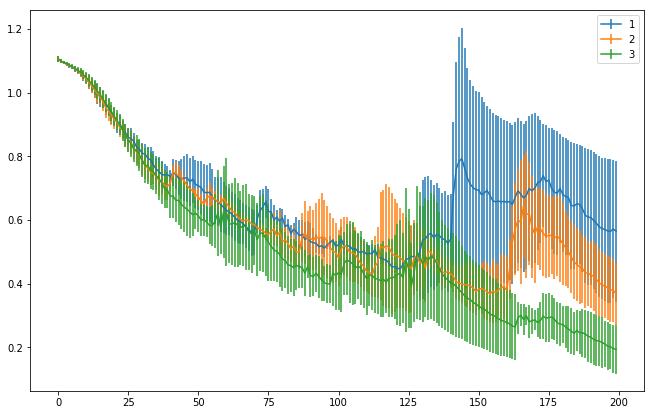

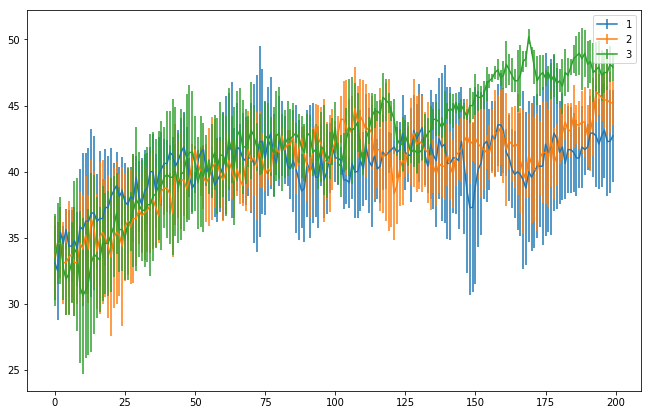

In [8]:
steps = [1, 2, 3]
plot_timeseries(all_loss, steps)
plot_timeseries(all_acc, steps)

# FORCE

In [9]:
all_trials = read_dataset("passive_trials.h5")
all_loss, all_acc = train_across_lengths(all_trials, FORCE_CLASS_COLS)

all_loss = np.array(all_loss)
all_acc = np.array(all_acc)

100%|██████████| 200/200 [00:28<00:00,  7.13it/s]


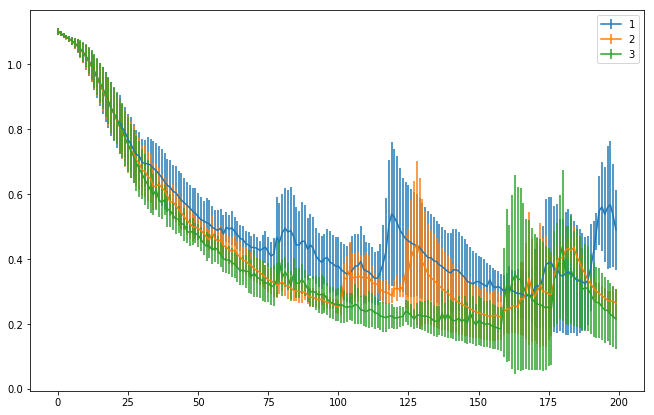

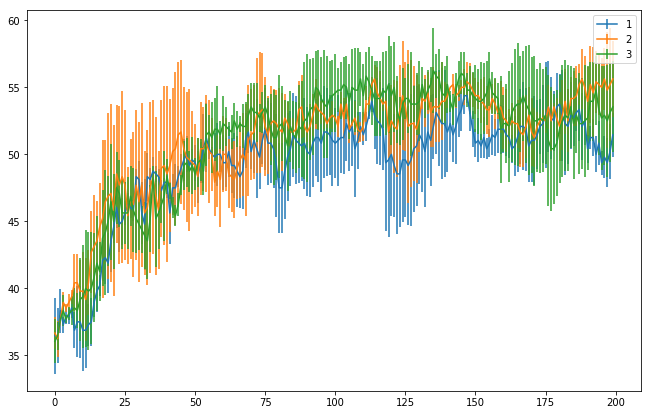

In [10]:
steps = [1, 2, 3]
plot_timeseries(all_loss, steps)
plot_timeseries(all_acc, steps)